[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slayoo/seattle-2026-workshop/blob/main/part_4_CCN_complete.ipynb)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils mendeleev pint PySDM

# hacking aerosol-cloud μ-physics modeling concepts in Python
### (mini-workshop @Uni. Washington Seattle, Jan 2026)

### Part 4: CCN activation model from scratch in Python (unit handling with Pint)

notebook authors (alphabetically): 
- Sylwester Arabas
- Daria Klimaszewska
- Emma Ware

This notebook implements a basic adiabatic air parcel model with moving-sectional (=super-droplet) aerosol-cloud spectrum description.
For reference on the employed theory and equations, see e.g. [Arabas & Shima 2017](https://doi.org/10.5194/npg-24-535-2017) (where the model is applied with a monodisperse droplet population. Note that the code below extends the model to a polydisperse case (to enable resolving the ripening proces), while for simplicity the size-spectrum is assumed to be sample with constant-multiplicity sampling.

### • representing a lognormal distribution of dry radii using deterministic constant-multiplicity sampling

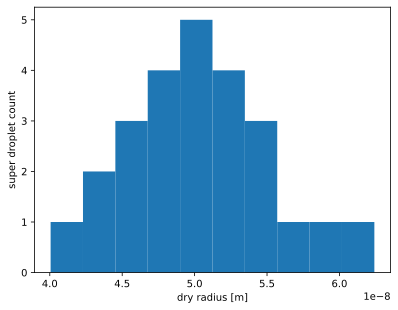

In [2]:
import numpy as np, scipy
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

σ_geom = 1.1
r_dry_median_metre = .05e-6
n_sd = 25

dry_radii_over_metre = scipy.stats.lognorm.ppf(
    np.linspace(.01, .99, n_sd),
    np.log(σ_geom),
    0,
    r_dry_median_metre
)

pyplot.hist(dry_radii_over_metre)
pyplot.gca().set(ylabel="super droplet count", xlabel="dry radius [m]")
show_plot()

### • constants (indices, fundamental/atmospheric physical constants, model parameters and initial state)

In [3]:
from collections import namedtuple
make_namedtuple = lambda name, items: namedtuple(name, items.keys())(*items.values())

ix = make_namedtuple("I", {
    "ln_rw": slice(0, n_sd),
    "pd": n_sd,
    "T": n_sd + 1,
    "size": n_sd + 2
})
print(ix)

I(ln_rw=slice(0, 25, None), pd=25, T=26, size=27)


In [4]:
from PySDM import physics
import mendeleev

def constants():
    SI = physics.si

    y0 = [0] * ix.size
    y0[ix.pd] = 1000 * SI.hPa
    y0[ix.T] = 300 * SI.K
    y0[ix.ln_rw] = np.log(dry_radii_over_metre)  # note: log(r) essential for solver stability by ensuring positivity of radii

    M_a = (
        0.78 * 2 * mendeleev.N.atomic_weight * SI.g / SI.mole + 
        0.21 * 2 * mendeleev.O.atomic_weight * SI.g / SI.mole + 
        0.01 * 1 * mendeleev.Ar.atomic_weight * SI.g / SI.mole
    )
    M_v = (
        1 * mendeleev.O.atomic_weight * SI.g / SI.mole + 
        2 * mendeleev.H.atomic_weight * SI.g / SI.mole
    )
    R_str = scipy.constants.R * SI.J / SI.K / SI.mole
    
    return make_namedtuple("C", {
        "R_d": R_str / M_a,
        "R_v": R_str / M_v,
        "cp_d": 1000 * SI.J / SI.kg / SI.K,
        "l_v": 45000 * SI.joule / SI.mol / M_v,
        "g": scipy.constants.g * SI.m / SI.s**2,
        "A": 1e-3 * SI.um,
        "rho_w": 1 * SI.kg / SI.litre,
        "D_eff": 2.3e-5 * SI.metre**2 / SI.s,
        "T0": scipy.constants.zero_Celsius * SI.K,

        "B80_G0": 6.112 * SI.hPa,
        "B80_G1": 17.67 * SI.dimensionless,
        "B80_G2": 243.5 * SI.K,
        
        "κ": 1.28,
        "w": 1 * SI.m / SI.s,
        "r_d": dry_radii_over_metre * SI.m,
        "xi": 1000 * 100**3 / n_sd,
        "m_d": 1 * SI.kg,
        "qt": 20 * SI.g / SI.kg,
        "t_max": 5 * SI.min,
        "y0": y0,
    }), SI

### • formulae expressing the math of the parcel-model (incl. diffusion of vapour around a droplet, hydrostatic and adiabatic conditions, ideal gas equation of state, relative humidity and size spectrum trivia)

In [5]:
formulae = make_namedtuple("F", {
    # eq. (1) in the NPG paper
    "dr_dt": lambda c, rw, rho_v, rho_o: c.D_eff / c.rho_w * (rho_v - rho_o) / rw,
    # eq. (4) in the NPG paper
    "RH_eq": lambda c, rw, rd: 1 + c.A / rw - c.κ * (rd / rw)**3,
    # eq. (13) in the NPG paper
    "dpd_dt": lambda c, rhod: -rhod * c.g * c.w,
    "dT_dt": lambda c, dpd_dt, dqv_dt, rhod: (dpd_dt / rhod - dqv_dt * c.l_v) / c.cp_d,
    # Bolton 1980 saturation vapour pressure formula (https://doi.org/10.1175/1520-0493(1980)108%3C1046:TCOEPT%3E2.0.CO;2)
    "pvs": lambda c, T: c.B80_G0 * np.exp((c.B80_G1 * (T - c.T0)) / ((T - c.T0) + c.B80_G2)),
    # trivia
    "rhod": lambda c, pd, T: pd / c.R_d / T,
    "rhov": lambda c, pv, T: pv / c.R_v / T,
    "RH": lambda c, rw3, rho_vs, rhod: rhod * (c.qt - c.xi * np.sum(rw3, axis=0) / c.m_d * 4/3 * np.pi * c.rho_w) / rho_vs,
    "dqv_dt": lambda c, rw, drw_dt: -4 * np.pi * c.xi * np.dot(rw**2, drw_dt) / c.m_d * c.rho_w,
})

### • plotting the [Köhler curves](https://en.wikipedia.org/wiki/K%C3%B6hler_theory) for selected of the sampled super droplets

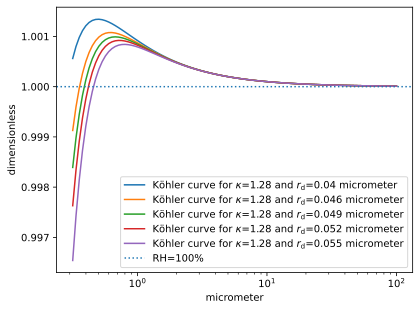

In [6]:
from PySDM.physics.dimensional_analysis import DimensionalAnalysis

with DimensionalAnalysis():
    c, SI = constants()
    SI.setup_matplotlib()
    for rd in c.r_d[::n_sd//5]:
        pyplot.semilogx(
            rw := np.logspace(-.5, 2, 100) * SI.um,
            formulae.RH_eq(c, rw=rw, rd=rd),
            label=f"Köhler curve for $κ$={c.κ} and $r_\\text{{d}}$={rd.to(SI.um):.2g}"
        )
    pyplot.axhline(1, label="RH=100%", linestyle=':')
    pyplot.legend()
show_plot()

### • defining the ODE system constituting the adiabatic parcel model and JIT-compiling it using Numba

In [7]:
import numba
jit_compile = numba.jit(error_model='numpy', fastmath=True)

In [8]:
jf = make_namedtuple("J", {k: jit_compile(v) for k, v in formulae._asdict().items()})

@jit_compile
def ode_rhs(_, y, c):
    rhod = jf.rhod(c, pd=y[ix.pd], T=y[ix.T])
    rho_vs = jf.rhov(c, pv=jf.pvs(c, y[ix.T]), T=y[ix.T])
    rw = np.exp(y[ix.ln_rw])
    RH = jf.RH(c, rw3=rw**3, rho_vs=rho_vs, rhod=rhod)
    RH_eq = jf.RH_eq(c, rw=rw, rd=c.r_d)
    
    dy_dt = np.empty_like(y)
    dy_dt[ix.pd] = jf.dpd_dt(c, rhod=rhod)
    dy_dt[ix.ln_rw] = jf.dr_dt(c, rw=rw, rho_v=RH * rho_vs, rho_o=RH_eq * rho_vs) / rw
    dy_dt[ix.T] = jf.dT_dt(c, dpd_dt=dy_dt[ix.pd], dqv_dt=jf.dqv_dt(c, rw=rw, drw_dt=dy_dt[ix.ln_rw] * rw), rhod=rhod)
    return dy_dt

### • integrating the ODE system using [SciPy's wrapper of the of Fortran LSODA solver from ODEPACK](https://docs.scipy.org/doc/scipy-1.17.0/reference/generated/scipy.integrate.solve_ivp.html) 

In [9]:
c, SI = constants()
solution = scipy.integrate.solve_ivp(
    ode_rhs, 
    (0, c.t_max),
    c.y0,
    max_step=.5 * SI.s,
    args=(c,),
    method='LSODA',
)
assert solution.success, solution.message

### • sample visualisation of the solution (leveraging Pint's support for auto-labelling of matplotlib plots)

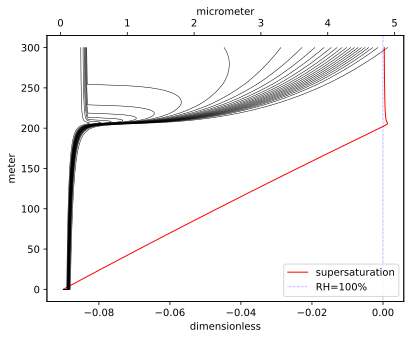

In [10]:
with DimensionalAnalysis():
    c, SI = constants()
    SI.setup_matplotlib()

    t = solution.t * SI.s
    pd = solution.y[ix.pd] * SI.Pa
    T = solution.y[ix.T] * SI.K
    rw = np.exp(solution.y[ix.ln_rw]) * SI.m
    RH = formulae.RH(c,
                     rw3=rw**3,
                     rho_vs=formulae.rhov(c, pv=formulae.pvs(c, T), T=T),
                     rhod=formulae.rhod(c, pd=pd, T=T)
                    )
    
    pyplot.plot(RH - 1, t * c.w, label="supersaturation", color='red', linewidth=1)
    pyplot.axvline(0, label="RH=100%", linestyle=':', color='blue', linewidth=.5)
    pyplot.legend(loc='lower right')
    
    twin = pyplot.gca().twiny()
    for i in range(ix.ln_rw.start, ix.ln_rw.stop):
        twin.plot(rw[i], t * c.w, color='k', linewidth=.5)
    twin.xaxis.set_units(SI.um)
show_plot()

### • further reading on Ostwald ripening in clouds
- [Arenberg 1939 (J. Atmos. Sci.)](http://doi.org/10.1175/1520-0477-20.10.444) cited by: [Google Scholar](https://scholar.google.com/scholar?cites=8244002676805439446)  
  "_Turbulence As The Major Factor in the Growth of Cloud Drops_"   
  > By   taking   the   average    values    of    vapor    pressure,    mass   of   drops,   and   supersaturation   over  a  complete  cycle,  it  can  be  shown  that  the  larger   drops  will   require   a   somewhat  unsaturated  average  vapor  pressure  to  maintain  a  constant  size, while  the   smaller   drops  will   need  a  more    nearly    saturated    atmosphere.    In  a  mixture  of  the  two  drops,  both  will  pool  their  excess  vapor  in  their  common   environment   during   heating   and   later   extract   it   during   cooling.   Both  will  experience  the  same  degree  of   supersaturation  which  will  be  the  resultant   determined   by  the   relative   numbers  and  requirements  of  the  different  sizes.    Since  this  value  will  be  greater   than   that   demanded   by   the   large   drops   and   less   than   that   for   the  small  ones,  the  former  will  grow  at  the  expense  of  the  latter.
- [Hagen 1979](https://doi.org/10.1175/1520-0450%281979%29018%3C1035:ANCMFT%3E2.0.CO;2)   
  "_A Numerical Cloud Model for the Support of Laboratory Experimentation_"
  > Three types of experiments are treated: cloud formation, droplet growth and Ostwald ripening
- [Tsang & Brock 1984](https://doi.org/10.1080/02786828408959016)   
  "_On Ostwald Ripening_"
- [Tsang & Brock 1986](https://doi.org/10.1080/02786828608959103)   
  "_Dynamics of Ostwald Ripening with Coalescencefor Aerosols with Continuum Diffusive Growth Laws_"
- [Barrett & Clement 1988](https://doi.org/10.1016/0021-8502(88)90225-X)   
  "_Growth rates for liquid drops_"
  > We show that radiation can strongly influence droplet growth and, not only in the atmosphere
as was previously pointed out by Barkstrom, induce changes in size distributions in clouds by
transferring mass from small to large droplets in radiatively cooling clouds which have no net growth,
the magnitude of the effect being much greater for larger droplets than the Ostwald ripening process.
- [Gelbard 1990](https://doi.org/10.1080/02786829008959355)   
  "_Modeling Multicomponent Aerosol Particle GrowthBy Vapor Condensation_"  
- [Kulmala et al. 1992](https://doi.org/10.1016/0021-8502%2892%2990362-Y)   
  "_Activation and growth of cloud condensation nuclei by binary nucleation and condensation processes_"
  > After about ten seconds the condensation rate has increased so much that the water saturation passes its maximum and particles which have not reached a size large enough start to evaporate due to the Kelvin effect (Ostwald ripening).
- [Srivastava 1991](http://doi.org/10.1175/1520-0469%281991%29048<1596%3AGOCDBC>2.0.CO%3B2)   
  "_Growth of Cloud Drops by Condensation: Effect of Surface Tension on the Dispersion of Drop Sizes_"
- [Sagui & Desai 1995 (Phys. Rev. Lett. 74)](https://doi.org/10.1103/PhysRevLett.74.1119)   
  "_Ostwald Ripening in Systems with Competing Interactions_"
- [Vesala 1997](https://doi.org/10.1016/S0021-8502(96)00461-2)    
  "_Models for condensational growth and evaporation of binary aerosol particles_"
- [Çelik and Marwitz 1999](https://doi.org/10.1175/1520-0469%281999%29056%3C3091:DSBBRP%3E2.0.CO;2)   
  "_Droplet Spectra Broadening by Ripening Process. Part I: Roles of Curvature and Salinity of Cloud Droplets_"
- [Wood et al. 2002](https://doi.org/10.1175/1520-0469%282002%29059%3C2681:HIITSR%3E2.0.CO;2)    
  "_How Important Is the Spectral Ripening Effect in Stratiform Boundary Layer Clouds? Studies Using Simple Trajectory Analysis_"
  > Recent modeling efforts (Celik and Marwitz 1999, henceforth CM99) have shown that parcels of air that remain within a cloud for significant periods of time undergo a ripening process whereby large droplets can grow at the expense of smaller droplets. This has been termed “Ostwald ripening,” following pioneering observations of crystals in 1896 by W. Ostwald. Because larger droplets grow and smaller droplets shrink, the effect of this process is to broaden the spectrum at both small and large sizes. Srivastava (1991) demonstrates, using the droplet growth equation, that the difference between the squared radii of any two activated nuclei is expected to increase with time, rather than remain constant, if the effect of droplet surface tension is included.
- [Pego 2007](http://www.math.cmu.edu/CNA/Publications/publications2006/001abs/001abs.html)   
  "_Lectures on dynamics in models of coarsening and coagulation_"    
  > One of the classic dynamic scaling phenomenaobserved in material systems is Ostwald ripening, a process that occursduring the condensation of a supersaturated vapor, for example (think of clouds or fog), or during phase separation in metallic alloys.
- [Lewellen 2012](https://doi.org/10.1175/JAS-D-11-029.1)    
  "_Analytic Solutions for Evolving Size Distributions of Spherical Crystals or Droplets Undergoing Diffusional Growth in Different Regimes_"   
  > In the limit of zero external forcing on the parcel the size-spectrum solution is mathematically equivalent to a classic result in the theory of Ostwald ripening of solid solutions. It is argued that the slow-growth regime may be important in the evolution of contrail cirrus and perhaps in setting upper limits on droplet number densities in stratiform boundary layer clouds. 
- [Baumgartner and Spichtinger 2018](https://doi.org/10.5194/acp-18-2525-2018)   
  "_Towards a bulk approach to local interactions of hydrometeors_"   
  > Note that the Wegener–Bergeron–Findeisen process is different from the Ostwald ripening, in which bigger particles grow at the expense of smaller particles due to the curvature dependency of the saturation pressure
- [Yang_et_al_2018 (Atmos. Chem. Phys. 18)](http://doi.org/10.5194/acp-18-7313-2018)   
  "_Cloud droplet size distribution broadening during diffusional growth: ripening amplified by deactivation and reactivation_"   
  > Results show that the CDSD can be broadened during condensational growth as a result of Ostwald ripening amplified by droplet deactivation and reactivation
- [Chandrakar et al. 2019 (QJRMS)](https://doi.org/10.1002/qj.3692)   
  "_Droplet size distributions in turbulent clouds: experimental evaluation of theoretical distributions_"
  > ... optimal distribution breaks down for broad aerosol size distributions, primarily due to deviations from the measured large-droplet tail. A possible explanation for the deviation is the Ostwald ripening effect coupled with deactivation/activation in polluted cloud conditions
- [Grabowski & Pawlowska 2023](https://doi.org/10.1029/2022GL101917)    
  "_Adiabatic Evolution of Cloud Droplet Spectral Width: A New Look at an Old Problem_"
  > Red lines show CCN classes that become activated and subsequently deactivated. 

### • animation depicting cloud-droplet concentration profile & spectra (in reply to Rob's e-mail)


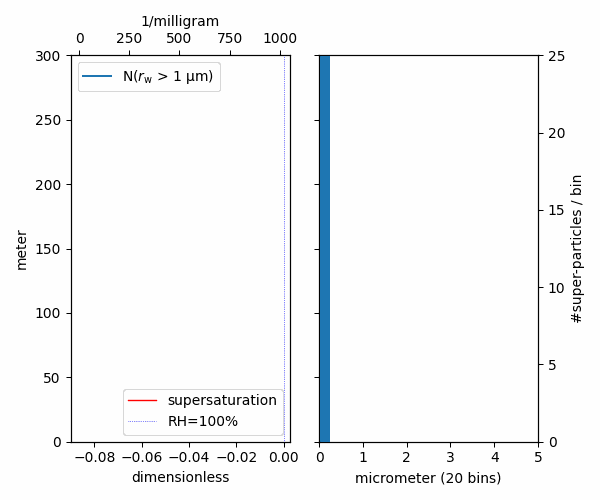

HTML(value="<a href='./tmpepq7l121.gif' target='_blank'>./tmpepq7l121.gif</a><br>")

In [13]:
from open_atmos_jupyter_utils import show_anim

S = RH - 1
z = t * c.w
Nc = np.count_nonzero(rw > (rc_threshold := 1 * SI.um), axis=0) * c.xi / c.m_d
rc = np.where(rw > rc_threshold, rw, np.nan)
i_cloud_base = np.argmax(np.any(np.isfinite(rc), axis=0))

def plot_frame(i):
    fig, axs = pyplot.subplot_mosaic([["conc", "spec"]], tight_layout=True, sharey=True, figsize=(6,5))
    
    axs["conc"].plot(S[:i], z[:i], color='red', linewidth=1, label='supersaturation')
    axs["conc"].axvline(0, label="RH=100%", linestyle=':', color='blue', linewidth=.5)
    axs["conc"].set(
        xlim=(min(S), 2 * max(S)),
        ylim=(min(z), max(z))
    )
    axs["conc"].legend(loc="lower right")
    
    twin_c = axs["conc"].twiny()
    twin_c.plot(Nc[:i], z[:i], label=f"N($r_\\text{{w}}$ > {rc_threshold:~P})")
    twin_c.xaxis.set_units(SI.mg**-1)
    twin_c.set(xlim=(-.05 * max(Nc), 1.25 * max(Nc)))
    twin_c.legend(loc="upper left")

    twin_s = axs["spec"].twinx()
    counts, bins = np.histogram(
        rw[:, i].to(bin_unit := SI.um).magnitude,
        range=(bin_range := (0, np.amax(rw).to(bin_unit).magnitude // 1 + 1)),
        bins=20,
    )
    twin_s.xaxis.set_units(bin_unit)
    twin_s.stairs(counts, bins * bin_unit, fill=True)
    twin_s.set(
        xlim=bin_range,
        ylim=(0, n_sd),
        ylabel="#super-particles / bin",
    )

    axs["spec"].set(xlabel=f"{bin_unit} ({len(counts)} bins)")
    if i >= i_cloud_base:
        i_cb = i
        mean = np.nanmean(rc[:,i_cloud_base:i], axis=0)
        stdv = np.nanstd(rc[:,i_cloud_base:i], axis=0)
        for mult in (-1, 0, 1):
            axs["spec"].plot(
                mean + mult * stdv,
                z[i_cloud_base:i],
                color='orange',
                linewidth=1.5 - abs(mult),
                label={
                    -1: '',
                    0: f'<$r_\\text{{w}}$>$|_{{r_\\text{{w}}>{rc_threshold:~P}}}$',
                    1: "+/- std. dev.",
                }[mult]
            )
        axs["spec"].legend(loc='center')
    
    return fig

show_anim(plot_frame, range(1, len(t), every_n_step := 2))